#Surface Defect Detection of Magnetic Tile

##Install the NVIDIA System Management Interface

In [1]:
!ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi
!nvcc --version

/opt/bin/nvidia-smi  /usr/bin/nvidia-smi
Sun Feb 28 13:13:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

##Download datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
!unzip data.zip

In [4]:
!mv Magnetic-tile-defect-datasets.-master data

##Library imports and the environment setting

In [5]:
%%capture
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image
#ImageFile.LOAD_TRUNCATED_IMAGES = True

!pip install torch
!pip install torchvision
!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm

!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [6]:
from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import SurfaceDefectDetectionDataset, partitioning
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics

In [7]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [8]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(51)

##Set the parameters

In [9]:
batch_size = 32    # batch_size for the train and validation set
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 200
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set to True to find the maximum learning rate
criterion_type = 'TverskyLoss'  """ Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section"""  
classes =['Blowhole', 'Crack','Free'] # classes/labels
split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

## Dataset

In [10]:
partition = partitioning(split_ratio)

Blowhole _  train:  80   val:  11   test:  24   total:  115
Crack _  train:  39   val:  6   test:  12   total:  57
Free _  train:  56   val:  7   test:  17   total:  80


In [11]:
# Construct the transformed dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

### Visualize sample images along with their masks

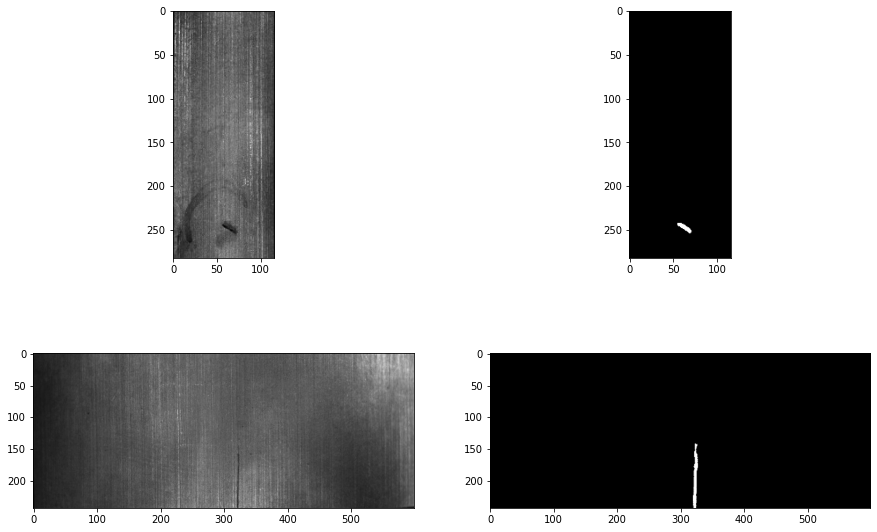

In [12]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(15, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')

###Visualize transforms on sample images and masks


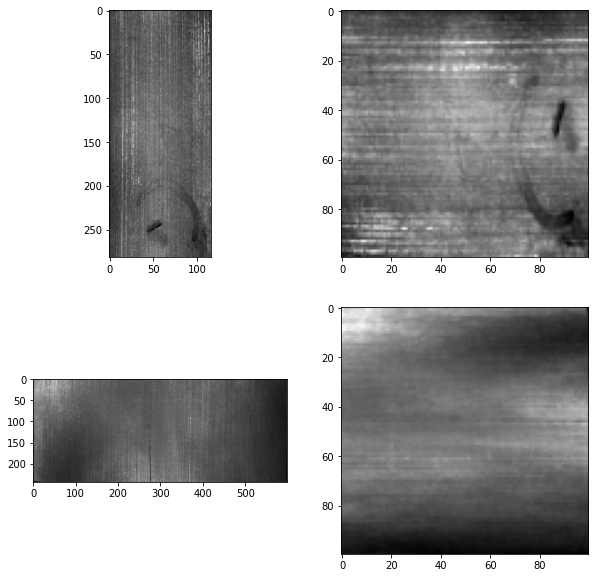

In [13]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(10, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg')
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((100,100))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')


### Some stats about the dataset

In [14]:
#fing the range of height and width of train images
H = []
W = []
pair = []
for p in partition['train']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 403 	maximum width: 618 	minimum height: 231 	minimum width: 105


In [15]:
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))

Length of train dataset:  175
Length of validation dataset:  24
Length of test dataset:  53


In [16]:
#find the weight of positive and negative pixels
positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in surface_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (224 * 224)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.0020520909256559767 	negative weight =  0.997947909074344


## Batch and load data

In [17]:
# Generators: load data in batches
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
                                              batch_size= test_batch_size, 
                                              shuffle=False, 
                                              num_workers=num_workers)


## Obtain model architecture

In [18]:
# instantiate the unet
model = UNet_2D(1,1,32,0.2).cuda()

In [19]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [20]:
summary(model, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             288
       BatchNorm2d-2         [32, 32, 224, 224]              64
              SiLU-3         [32, 32, 224, 224]               0
            Conv2d-4         [32, 32, 224, 224]           9,216
       BatchNorm2d-5         [32, 32, 224, 224]              64
              SiLU-6         [32, 32, 224, 224]               0
         MaxPool2d-7         [32, 32, 112, 112]               0
           Dropout-8         [32, 32, 112, 112]               0
            Conv2d-9         [32, 64, 112, 112]          18,432
      BatchNorm2d-10         [32, 64, 112, 112]             128
             SiLU-11         [32, 64, 112, 112]               0
           Conv2d-12         [32, 64, 112, 112]          36,864
      BatchNorm2d-13         [32, 64, 112, 112]             128
             SiLU-14         [32, 64, 1

## Specify the loss function and optimizer

In [21]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [22]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

## Train and validate the model

In [23]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')                

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  0%|          | 1/201 [00:03<13:05,  3.93s/it]

Epoch: 1 	Training Loss: 0.9951 	Validation Loss: 0.9974
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 6...


  1%|          | 2/201 [00:05<10:44,  3.24s/it]

=== Validation ===
1 / 1...
Epoch: 2 	Training Loss: 0.9929 	Validation Loss: 0.9975
=== Epoch #3 ===
=== Training ===
1 / 6...


  1%|▏         | 3/201 [00:07<09:05,  2.76s/it]

=== Validation ===
1 / 1...
Epoch: 3 	Training Loss: 0.9926 	Validation Loss: 0.9975
=== Epoch #4 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 4 	Training Loss: 0.9916 	Validation Loss: 0.9969
Validation loss decreased.  Saving model ...


  2%|▏         | 4/201 [00:08<07:59,  2.43s/it]

=== Epoch #5 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 5 	Training Loss: 0.9913 	Validation Loss: 0.9947
Validation loss decreased.  Saving model ...


  2%|▏         | 5/201 [00:10<07:13,  2.21s/it]

=== Epoch #6 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 6 	Training Loss: 0.9915 	Validation Loss: 0.9941
Validation loss decreased.  Saving model ...


  3%|▎         | 6/201 [00:12<06:39,  2.05s/it]

=== Epoch #7 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 7 	Training Loss: 0.9909 	Validation Loss: 0.9924
Validation loss decreased.  Saving model ...


  3%|▎         | 7/201 [00:13<06:16,  1.94s/it]

=== Epoch #8 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 8 	Training Loss: 0.9906 	Validation Loss: 0.9903
Validation loss decreased.  Saving model ...


  4%|▍         | 8/201 [00:15<06:00,  1.87s/it]

=== Epoch #9 ===
=== Training ===
1 / 6...


  4%|▍         | 9/201 [00:17<05:44,  1.79s/it]

=== Validation ===
1 / 1...
Epoch: 9 	Training Loss: 0.9902 	Validation Loss: 0.9908
=== Epoch #10 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 10 	Training Loss: 0.9899 	Validation Loss: 0.9896
Validation loss decreased.  Saving model ...


  5%|▍         | 10/201 [00:18<05:36,  1.76s/it]

=== Epoch #11 ===
=== Training ===
1 / 6...


  5%|▌         | 11/201 [00:20<05:25,  1.71s/it]

=== Validation ===
1 / 1...
Epoch: 11 	Training Loss: 0.9895 	Validation Loss: 0.9900
=== Epoch #12 ===
=== Training ===
1 / 6...


  6%|▌         | 12/201 [00:22<05:17,  1.68s/it]

=== Validation ===
1 / 1...
Epoch: 12 	Training Loss: 0.9886 	Validation Loss: 0.9897
=== Epoch #13 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 13 	Training Loss: 0.9877 	Validation Loss: 0.9888
Validation loss decreased.  Saving model ...


  6%|▋         | 13/201 [00:23<05:15,  1.68s/it]

=== Epoch #14 ===
=== Training ===
1 / 6...


  7%|▋         | 14/201 [00:25<05:11,  1.67s/it]

=== Validation ===
1 / 1...
Epoch: 14 	Training Loss: 0.9877 	Validation Loss: 0.9893
=== Epoch #15 ===
=== Training ===
1 / 6...


  7%|▋         | 15/201 [00:27<05:07,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 15 	Training Loss: 0.9861 	Validation Loss: 0.9888
=== Epoch #16 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 16 	Training Loss: 0.9860 	Validation Loss: 0.9867
Validation loss decreased.  Saving model ...


  8%|▊         | 16/201 [00:28<05:06,  1.66s/it]

=== Epoch #17 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 17 	Training Loss: 0.9856 	Validation Loss: 0.9851
Validation loss decreased.  Saving model ...


  8%|▊         | 17/201 [00:30<05:06,  1.66s/it]

=== Epoch #18 ===
=== Training ===
1 / 6...


  9%|▉         | 18/201 [00:32<05:01,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 18 	Training Loss: 0.9850 	Validation Loss: 0.9873
=== Epoch #19 ===
=== Training ===
1 / 6...


  9%|▉         | 19/201 [00:33<04:58,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 19 	Training Loss: 0.9844 	Validation Loss: 0.9885
=== Epoch #20 ===
=== Training ===
1 / 6...


 10%|▉         | 20/201 [00:35<04:56,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 20 	Training Loss: 0.9822 	Validation Loss: 0.9864
=== Epoch #21 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 21 	Training Loss: 0.9807 	Validation Loss: 0.9833
Validation loss decreased.  Saving model ...


 10%|█         | 21/201 [00:36<04:57,  1.65s/it]

=== Epoch #22 ===
=== Training ===
1 / 6...


 11%|█         | 22/201 [00:38<04:53,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 22 	Training Loss: 0.9793 	Validation Loss: 0.9861
=== Epoch #23 ===
=== Training ===
1 / 6...


 11%|█▏        | 23/201 [00:40<04:50,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 23 	Training Loss: 0.9779 	Validation Loss: 0.9853
=== Epoch #24 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 24 	Training Loss: 0.9753 	Validation Loss: 0.9817
Validation loss decreased.  Saving model ...


 12%|█▏        | 24/201 [00:41<04:51,  1.65s/it]

=== Epoch #25 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 25 	Training Loss: 0.9726 	Validation Loss: 0.9786
Validation loss decreased.  Saving model ...


 12%|█▏        | 25/201 [00:43<04:52,  1.66s/it]

=== Epoch #26 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 26 	Training Loss: 0.9719 	Validation Loss: 0.9780
Validation loss decreased.  Saving model ...


 13%|█▎        | 26/201 [00:45<04:51,  1.67s/it]

=== Epoch #27 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 27 	Training Loss: 0.9669 	Validation Loss: 0.9753
Validation loss decreased.  Saving model ...


 13%|█▎        | 27/201 [00:46<04:51,  1.67s/it]

=== Epoch #28 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 28 	Training Loss: 0.9634 	Validation Loss: 0.9691
Validation loss decreased.  Saving model ...


 14%|█▍        | 28/201 [00:48<04:51,  1.68s/it]

=== Epoch #29 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 29 	Training Loss: 0.9601 	Validation Loss: 0.9676
Validation loss decreased.  Saving model ...


 14%|█▍        | 29/201 [00:50<04:49,  1.68s/it]

=== Epoch #30 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 30 	Training Loss: 0.9551 	Validation Loss: 0.9647
Validation loss decreased.  Saving model ...


 15%|█▍        | 30/201 [00:51<04:47,  1.68s/it]

=== Epoch #31 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 31 	Training Loss: 0.9510 	Validation Loss: 0.9596
Validation loss decreased.  Saving model ...


 15%|█▌        | 31/201 [00:53<04:46,  1.68s/it]

=== Epoch #32 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 32 	Training Loss: 0.9384 	Validation Loss: 0.9578
Validation loss decreased.  Saving model ...


 16%|█▌        | 32/201 [00:55<04:45,  1.69s/it]

=== Epoch #33 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 33 	Training Loss: 0.9396 	Validation Loss: 0.9454
Validation loss decreased.  Saving model ...


 16%|█▋        | 33/201 [00:57<04:45,  1.70s/it]

=== Epoch #34 ===
=== Training ===
1 / 6...


 17%|█▋        | 34/201 [00:58<04:39,  1.67s/it]

=== Validation ===
1 / 1...
Epoch: 34 	Training Loss: 0.9288 	Validation Loss: 0.9472
=== Epoch #35 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 35 	Training Loss: 0.9150 	Validation Loss: 0.9191
Validation loss decreased.  Saving model ...


 17%|█▋        | 35/201 [01:00<04:38,  1.68s/it]

=== Epoch #36 ===
=== Training ===
1 / 6...


 18%|█▊        | 36/201 [01:02<04:33,  1.66s/it]

=== Validation ===
1 / 1...
Epoch: 36 	Training Loss: 0.9051 	Validation Loss: 0.9206
=== Epoch #37 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 37 	Training Loss: 0.8823 	Validation Loss: 0.8958
Validation loss decreased.  Saving model ...


 18%|█▊        | 37/201 [01:03<04:33,  1.67s/it]

=== Epoch #38 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 38 	Training Loss: 0.8567 	Validation Loss: 0.8691
Validation loss decreased.  Saving model ...


 19%|█▉        | 38/201 [01:05<04:32,  1.67s/it]

=== Epoch #39 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 39 	Training Loss: 0.8450 	Validation Loss: 0.8556
Validation loss decreased.  Saving model ...


 19%|█▉        | 39/201 [01:07<04:31,  1.68s/it]

=== Epoch #40 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 40 	Training Loss: 0.8243 	Validation Loss: 0.8030
Validation loss decreased.  Saving model ...


 20%|█▉        | 40/201 [01:08<04:29,  1.67s/it]

=== Epoch #41 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 41 	Training Loss: 0.7808 	Validation Loss: 0.7684
Validation loss decreased.  Saving model ...


 20%|██        | 41/201 [01:10<04:27,  1.67s/it]

=== Epoch #42 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 42 	Training Loss: 0.7572 	Validation Loss: 0.7627
Validation loss decreased.  Saving model ...


 21%|██        | 42/201 [01:12<04:26,  1.67s/it]

=== Epoch #43 ===
=== Training ===
1 / 6...


 21%|██▏       | 43/201 [01:13<04:21,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 43 	Training Loss: 0.7241 	Validation Loss: 0.8303
=== Epoch #44 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 44 	Training Loss: 0.7085 	Validation Loss: 0.7569
Validation loss decreased.  Saving model ...


 22%|██▏       | 44/201 [01:15<04:24,  1.68s/it]

=== Epoch #45 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 45 	Training Loss: 0.6439 	Validation Loss: 0.6878
Validation loss decreased.  Saving model ...


 22%|██▏       | 45/201 [01:17<04:22,  1.68s/it]

=== Epoch #46 ===
=== Training ===
1 / 6...


 23%|██▎       | 46/201 [01:18<04:16,  1.66s/it]

=== Validation ===
1 / 1...
Epoch: 46 	Training Loss: 0.6466 	Validation Loss: 0.7645
=== Epoch #47 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 47 	Training Loss: 0.6046 	Validation Loss: 0.6601
Validation loss decreased.  Saving model ...


 23%|██▎       | 47/201 [01:20<04:18,  1.68s/it]

=== Epoch #48 ===
=== Training ===
1 / 6...


 24%|██▍       | 48/201 [01:22<04:13,  1.66s/it]

=== Validation ===
1 / 1...
Epoch: 48 	Training Loss: 0.5512 	Validation Loss: 0.6908
=== Epoch #49 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 49 	Training Loss: 0.5141 	Validation Loss: 0.6526
Validation loss decreased.  Saving model ...


 24%|██▍       | 49/201 [01:23<04:13,  1.67s/it]

=== Epoch #50 ===
=== Training ===
1 / 6...


 25%|██▍       | 50/201 [01:25<04:08,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 50 	Training Loss: 0.4853 	Validation Loss: 0.7253
=== Epoch #51 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 51 	Training Loss: 0.4657 	Validation Loss: 0.5780
Validation loss decreased.  Saving model ...


 25%|██▌       | 51/201 [01:27<04:08,  1.66s/it]

=== Epoch #52 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 52 	Training Loss: 0.4181 	Validation Loss: 0.5726
Validation loss decreased.  Saving model ...


 26%|██▌       | 52/201 [01:28<04:07,  1.66s/it]

=== Epoch #53 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 53 	Training Loss: 0.4101 	Validation Loss: 0.5353
Validation loss decreased.  Saving model ...


 26%|██▋       | 53/201 [01:30<04:06,  1.66s/it]

=== Epoch #54 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 54 	Training Loss: 0.3710 	Validation Loss: 0.4110
Validation loss decreased.  Saving model ...


 27%|██▋       | 54/201 [01:32<04:05,  1.67s/it]

=== Epoch #55 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 55 	Training Loss: 0.3816 	Validation Loss: 0.3956
Validation loss decreased.  Saving model ...


 27%|██▋       | 55/201 [01:33<04:05,  1.68s/it]

=== Epoch #56 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 56 	Training Loss: 0.3940 	Validation Loss: 0.3290
Validation loss decreased.  Saving model ...


 28%|██▊       | 56/201 [01:35<04:03,  1.68s/it]

=== Epoch #57 ===
=== Training ===
1 / 6...


 28%|██▊       | 57/201 [01:37<03:58,  1.66s/it]

=== Validation ===
1 / 1...
Epoch: 57 	Training Loss: 0.3475 	Validation Loss: 0.3781
=== Epoch #58 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 58 	Training Loss: 0.3718 	Validation Loss: 0.3134
Validation loss decreased.  Saving model ...


 29%|██▉       | 58/201 [01:38<03:57,  1.66s/it]

=== Epoch #59 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 59 	Training Loss: 0.3026 	Validation Loss: 0.2883
Validation loss decreased.  Saving model ...


 29%|██▉       | 59/201 [01:40<03:57,  1.67s/it]

=== Epoch #60 ===
=== Training ===
1 / 6...


 30%|██▉       | 60/201 [01:42<03:53,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 60 	Training Loss: 0.3407 	Validation Loss: 0.3676
=== Epoch #61 ===
=== Training ===
1 / 6...


 30%|███       | 61/201 [01:43<03:49,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 61 	Training Loss: 0.3082 	Validation Loss: 0.3126
=== Epoch #62 ===
=== Training ===
1 / 6...


 31%|███       | 62/201 [01:45<03:46,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 62 	Training Loss: 0.3217 	Validation Loss: 0.3294
=== Epoch #63 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 63 	Training Loss: 0.3061 	Validation Loss: 0.2855
Validation loss decreased.  Saving model ...


 31%|███▏      | 63/201 [01:46<03:46,  1.64s/it]

=== Epoch #64 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 64 	Training Loss: 0.3220 	Validation Loss: 0.2670
Validation loss decreased.  Saving model ...


 32%|███▏      | 64/201 [01:48<03:47,  1.66s/it]

=== Epoch #65 ===
=== Training ===
1 / 6...


 32%|███▏      | 65/201 [01:50<03:42,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 65 	Training Loss: 0.3055 	Validation Loss: 0.2852
=== Epoch #66 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 66 	Training Loss: 0.2815 	Validation Loss: 0.2568
Validation loss decreased.  Saving model ...


 33%|███▎      | 66/201 [01:51<03:42,  1.65s/it]

=== Epoch #67 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 67 	Training Loss: 0.2888 	Validation Loss: 0.2474
Validation loss decreased.  Saving model ...


 33%|███▎      | 67/201 [01:53<03:41,  1.65s/it]

=== Epoch #68 ===
=== Training ===
1 / 6...


 34%|███▍      | 68/201 [01:55<03:38,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 68 	Training Loss: 0.3106 	Validation Loss: 0.2663
=== Epoch #69 ===
=== Training ===
1 / 6...


 34%|███▍      | 69/201 [01:56<03:35,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 69 	Training Loss: 0.2821 	Validation Loss: 0.3166
=== Epoch #70 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 70 	Training Loss: 0.2606 	Validation Loss: 0.2402
Validation loss decreased.  Saving model ...


 35%|███▍      | 70/201 [01:58<03:37,  1.66s/it]

=== Epoch #71 ===
=== Training ===
1 / 6...


 35%|███▌      | 71/201 [02:00<03:33,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 71 	Training Loss: 0.2619 	Validation Loss: 0.2519
=== Epoch #72 ===
=== Training ===
1 / 6...


 36%|███▌      | 72/201 [02:01<03:31,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 72 	Training Loss: 0.2682 	Validation Loss: 0.2743
=== Epoch #73 ===
=== Training ===
1 / 6...


 36%|███▋      | 73/201 [02:03<03:29,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 73 	Training Loss: 0.2951 	Validation Loss: 0.2433
=== Epoch #74 ===
=== Training ===
1 / 6...


 37%|███▋      | 74/201 [02:04<03:27,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 74 	Training Loss: 0.2534 	Validation Loss: 0.2861
=== Epoch #75 ===
=== Training ===
1 / 6...


 37%|███▋      | 75/201 [02:06<03:24,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 75 	Training Loss: 0.2679 	Validation Loss: 0.2965
=== Epoch #76 ===
=== Training ===
1 / 6...


 38%|███▊      | 76/201 [02:08<03:22,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 76 	Training Loss: 0.2387 	Validation Loss: 0.3478
=== Epoch #77 ===
=== Training ===
1 / 6...


 38%|███▊      | 77/201 [02:09<03:21,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 77 	Training Loss: 0.2570 	Validation Loss: 0.2915
=== Epoch #78 ===
=== Training ===
1 / 6...


 39%|███▉      | 78/201 [02:11<03:21,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 78 	Training Loss: 0.2641 	Validation Loss: 0.2843
=== Epoch #79 ===
=== Training ===
1 / 6...


 39%|███▉      | 79/201 [02:13<03:19,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 79 	Training Loss: 0.2274 	Validation Loss: 0.3107
=== Epoch #80 ===
=== Training ===
1 / 6...


 40%|███▉      | 80/201 [02:14<03:17,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 80 	Training Loss: 0.2383 	Validation Loss: 0.3063
=== Epoch #81 ===
=== Training ===
1 / 6...


 40%|████      | 81/201 [02:16<03:15,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 81 	Training Loss: 0.2410 	Validation Loss: 0.2695
=== Epoch #82 ===
=== Training ===
1 / 6...


 41%|████      | 82/201 [02:17<03:12,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 82 	Training Loss: 0.2333 	Validation Loss: 0.2415
=== Epoch #83 ===
=== Training ===
1 / 6...


 41%|████▏     | 83/201 [02:19<03:10,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 83 	Training Loss: 0.2407 	Validation Loss: 0.2403
=== Epoch #84 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 84 	Training Loss: 0.2551 	Validation Loss: 0.2368
Validation loss decreased.  Saving model ...


 42%|████▏     | 84/201 [02:21<03:12,  1.64s/it]

=== Epoch #85 ===
=== Training ===
1 / 6...


 42%|████▏     | 85/201 [02:22<03:09,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 85 	Training Loss: 0.2529 	Validation Loss: 0.2388
=== Epoch #86 ===
=== Training ===
1 / 6...


 43%|████▎     | 86/201 [02:24<03:08,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 86 	Training Loss: 0.2416 	Validation Loss: 0.2510
=== Epoch #87 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 87 	Training Loss: 0.2280 	Validation Loss: 0.2360
Validation loss decreased.  Saving model ...


 43%|████▎     | 87/201 [02:26<03:08,  1.66s/it]

=== Epoch #88 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 88 	Training Loss: 0.2222 	Validation Loss: 0.2203
Validation loss decreased.  Saving model ...


 44%|████▍     | 88/201 [02:27<03:09,  1.67s/it]

=== Epoch #89 ===
=== Training ===
1 / 6...


 44%|████▍     | 89/201 [02:29<03:05,  1.66s/it]

=== Validation ===
1 / 1...
Epoch: 89 	Training Loss: 0.2179 	Validation Loss: 0.2272
=== Epoch #90 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 90 	Training Loss: 0.2145 	Validation Loss: 0.2117
Validation loss decreased.  Saving model ...


 45%|████▍     | 90/201 [02:31<03:05,  1.67s/it]

=== Epoch #91 ===
=== Training ===
1 / 6...


 45%|████▌     | 91/201 [02:32<03:01,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 91 	Training Loss: 0.2261 	Validation Loss: 0.2131
=== Epoch #92 ===
=== Training ===
1 / 6...


 46%|████▌     | 92/201 [02:34<02:58,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 92 	Training Loss: 0.2084 	Validation Loss: 0.2215
=== Epoch #93 ===
=== Training ===
1 / 6...


 46%|████▋     | 93/201 [02:36<02:56,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 93 	Training Loss: 0.1986 	Validation Loss: 0.2331
=== Epoch #94 ===
=== Training ===
1 / 6...


 47%|████▋     | 94/201 [02:37<02:55,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 94 	Training Loss: 0.2091 	Validation Loss: 0.2410
=== Epoch #95 ===
=== Training ===
1 / 6...


 47%|████▋     | 95/201 [02:39<02:53,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 95 	Training Loss: 0.2215 	Validation Loss: 0.2365
=== Epoch #96 ===
=== Training ===
1 / 6...


 48%|████▊     | 96/201 [02:41<02:50,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 96 	Training Loss: 0.2189 	Validation Loss: 0.2214
=== Epoch #97 ===
=== Training ===
1 / 6...


 48%|████▊     | 97/201 [02:42<02:48,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 97 	Training Loss: 0.2055 	Validation Loss: 0.2459
=== Epoch #98 ===
=== Training ===
1 / 6...


 49%|████▉     | 98/201 [02:44<02:46,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 98 	Training Loss: 0.2136 	Validation Loss: 0.2542
=== Epoch #99 ===
=== Training ===
1 / 6...


 49%|████▉     | 99/201 [02:45<02:44,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 99 	Training Loss: 0.2089 	Validation Loss: 0.2211
=== Epoch #100 ===
=== Training ===
1 / 6...


 50%|████▉     | 100/201 [02:47<02:43,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 100 	Training Loss: 0.2117 	Validation Loss: 0.2398
=== Epoch #101 ===
=== Training ===
1 / 6...


 50%|█████     | 101/201 [02:49<02:41,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 101 	Training Loss: 0.2084 	Validation Loss: 0.2505
=== Epoch #102 ===
=== Training ===
1 / 6...


 51%|█████     | 102/201 [02:50<02:39,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 102 	Training Loss: 0.2176 	Validation Loss: 0.2259
=== Epoch #103 ===
=== Training ===
1 / 6...


 51%|█████     | 103/201 [02:52<02:37,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 103 	Training Loss: 0.2244 	Validation Loss: 0.3626
=== Epoch #104 ===
=== Training ===
1 / 6...


 52%|█████▏    | 104/201 [02:53<02:36,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 104 	Training Loss: 0.2979 	Validation Loss: 0.3203
=== Epoch #105 ===
=== Training ===
1 / 6...


 52%|█████▏    | 105/201 [02:55<02:34,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 105 	Training Loss: 0.2403 	Validation Loss: 0.2323
=== Epoch #106 ===
=== Training ===
1 / 6...


 53%|█████▎    | 106/201 [02:57<02:33,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 106 	Training Loss: 0.2235 	Validation Loss: 0.2353
=== Epoch #107 ===
=== Training ===
1 / 6...


 53%|█████▎    | 107/201 [02:58<02:33,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 107 	Training Loss: 0.2146 	Validation Loss: 0.2731
=== Epoch #108 ===
=== Training ===
1 / 6...


 54%|█████▎    | 108/201 [03:00<02:31,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 108 	Training Loss: 0.2364 	Validation Loss: 0.2688
=== Epoch #109 ===
=== Training ===
1 / 6...


 54%|█████▍    | 109/201 [03:02<02:29,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 109 	Training Loss: 0.2058 	Validation Loss: 0.2433
=== Epoch #110 ===
=== Training ===
1 / 6...


 55%|█████▍    | 110/201 [03:03<02:28,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 110 	Training Loss: 0.2225 	Validation Loss: 0.2556
=== Epoch #111 ===
=== Training ===
1 / 6...


 55%|█████▌    | 111/201 [03:05<02:26,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 111 	Training Loss: 0.2241 	Validation Loss: 0.2906
=== Epoch #112 ===
=== Training ===
1 / 6...


 56%|█████▌    | 112/201 [03:06<02:24,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 112 	Training Loss: 0.2238 	Validation Loss: 0.2780
=== Epoch #113 ===
=== Training ===
1 / 6...


 56%|█████▌    | 113/201 [03:08<02:22,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 113 	Training Loss: 0.2216 	Validation Loss: 0.2494
=== Epoch #114 ===
=== Training ===
1 / 6...


 57%|█████▋    | 114/201 [03:10<02:20,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 114 	Training Loss: 0.2297 	Validation Loss: 0.2590
=== Epoch #115 ===
=== Training ===
1 / 6...


 57%|█████▋    | 115/201 [03:11<02:18,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 115 	Training Loss: 0.2156 	Validation Loss: 0.2717
=== Epoch #116 ===
=== Training ===
1 / 6...


 58%|█████▊    | 116/201 [03:13<02:16,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 116 	Training Loss: 0.2003 	Validation Loss: 0.2997
=== Epoch #117 ===
=== Training ===
1 / 6...


 58%|█████▊    | 117/201 [03:14<02:14,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 117 	Training Loss: 0.2203 	Validation Loss: 0.2903
=== Epoch #118 ===
=== Training ===
1 / 6...


 59%|█████▊    | 118/201 [03:16<02:13,  1.60s/it]

=== Validation ===
1 / 1...
Epoch: 118 	Training Loss: 0.1943 	Validation Loss: 0.2519
=== Epoch #119 ===
=== Training ===
1 / 6...


 59%|█████▉    | 119/201 [03:18<02:11,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 119 	Training Loss: 0.1990 	Validation Loss: 0.2571
=== Epoch #120 ===
=== Training ===
1 / 6...


 60%|█████▉    | 120/201 [03:19<02:10,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 120 	Training Loss: 0.2075 	Validation Loss: 0.2451
=== Epoch #121 ===
=== Training ===
1 / 6...


 60%|██████    | 121/201 [03:21<02:08,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 121 	Training Loss: 0.1988 	Validation Loss: 0.2535
=== Epoch #122 ===
=== Training ===
1 / 6...


 61%|██████    | 122/201 [03:22<02:06,  1.60s/it]

=== Validation ===
1 / 1...
Epoch: 122 	Training Loss: 0.2028 	Validation Loss: 0.2440
=== Epoch #123 ===
=== Training ===
1 / 6...


 61%|██████    | 123/201 [03:24<02:04,  1.60s/it]

=== Validation ===
1 / 1...
Epoch: 123 	Training Loss: 0.1992 	Validation Loss: 0.2457
=== Epoch #124 ===
=== Training ===
1 / 6...


 62%|██████▏   | 124/201 [03:26<02:04,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 124 	Training Loss: 0.1920 	Validation Loss: 0.2508
=== Epoch #125 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 125 	Training Loss: 0.1846 	Validation Loss: 0.2029
Validation loss decreased.  Saving model ...


 62%|██████▏   | 125/201 [03:27<02:04,  1.64s/it]

=== Epoch #126 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...
Epoch: 126 	Training Loss: 0.1832 	Validation Loss: 0.2012
Validation loss decreased.  Saving model ...


 63%|██████▎   | 126/201 [03:29<02:04,  1.65s/it]

=== Epoch #127 ===
=== Training ===
1 / 6...


 63%|██████▎   | 127/201 [03:31<02:01,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 127 	Training Loss: 0.1831 	Validation Loss: 0.2013
=== Epoch #128 ===
=== Training ===
1 / 6...


 64%|██████▎   | 128/201 [03:32<01:59,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 128 	Training Loss: 0.1750 	Validation Loss: 0.2222
=== Epoch #129 ===
=== Training ===
1 / 6...


 64%|██████▍   | 129/201 [03:34<01:57,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 129 	Training Loss: 0.1894 	Validation Loss: 0.2294
=== Epoch #130 ===
=== Training ===
1 / 6...


 65%|██████▍   | 130/201 [03:36<01:54,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 130 	Training Loss: 0.1905 	Validation Loss: 0.2253
=== Epoch #131 ===
=== Training ===
1 / 6...


 65%|██████▌   | 131/201 [03:37<01:52,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 131 	Training Loss: 0.1850 	Validation Loss: 0.2288
=== Epoch #132 ===
=== Training ===
1 / 6...


 66%|██████▌   | 132/201 [03:39<01:51,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 132 	Training Loss: 0.1853 	Validation Loss: 0.2426
=== Epoch #133 ===
=== Training ===
1 / 6...


 66%|██████▌   | 133/201 [03:40<01:49,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 133 	Training Loss: 0.1941 	Validation Loss: 0.2346
=== Epoch #134 ===
=== Training ===
1 / 6...


 67%|██████▋   | 134/201 [03:42<01:47,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 134 	Training Loss: 0.1794 	Validation Loss: 0.2306
=== Epoch #135 ===
=== Training ===
1 / 6...


 67%|██████▋   | 135/201 [03:44<01:46,  1.61s/it]

=== Validation ===
1 / 1...
Epoch: 135 	Training Loss: 0.1872 	Validation Loss: 0.2340
=== Epoch #136 ===
=== Training ===
1 / 6...


 68%|██████▊   | 136/201 [03:45<01:45,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 136 	Training Loss: 0.1797 	Validation Loss: 0.2355
=== Epoch #137 ===
=== Training ===
1 / 6...


 68%|██████▊   | 137/201 [03:47<01:44,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 137 	Training Loss: 0.1976 	Validation Loss: 0.2335
=== Epoch #138 ===
=== Training ===
1 / 6...


 69%|██████▊   | 138/201 [03:48<01:42,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 138 	Training Loss: 0.1930 	Validation Loss: 0.2546
=== Epoch #139 ===
=== Training ===
1 / 6...


 69%|██████▉   | 139/201 [03:50<01:40,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 139 	Training Loss: 0.1848 	Validation Loss: 0.2865
=== Epoch #140 ===
=== Training ===
1 / 6...


 70%|██████▉   | 140/201 [03:52<01:39,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 140 	Training Loss: 0.1777 	Validation Loss: 0.3083
=== Epoch #141 ===
=== Training ===
1 / 6...


 70%|███████   | 141/201 [03:53<01:37,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 141 	Training Loss: 0.1853 	Validation Loss: 0.2993
=== Epoch #142 ===
=== Training ===
1 / 6...


 71%|███████   | 142/201 [03:55<01:36,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 142 	Training Loss: 0.1962 	Validation Loss: 0.2840
=== Epoch #143 ===
=== Training ===
1 / 6...


 71%|███████   | 143/201 [03:57<01:34,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 143 	Training Loss: 0.1756 	Validation Loss: 0.2786
=== Epoch #144 ===
=== Training ===
1 / 6...


 72%|███████▏  | 144/201 [03:58<01:33,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 144 	Training Loss: 0.1907 	Validation Loss: 0.2658
=== Epoch #145 ===
=== Training ===
1 / 6...


 72%|███████▏  | 145/201 [04:00<01:31,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 145 	Training Loss: 0.1716 	Validation Loss: 0.2295
=== Epoch #146 ===
=== Training ===
1 / 6...


 73%|███████▎  | 146/201 [04:02<01:29,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 146 	Training Loss: 0.1978 	Validation Loss: 0.2257
=== Epoch #147 ===
=== Training ===
1 / 6...


 73%|███████▎  | 147/201 [04:03<01:28,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 147 	Training Loss: 0.1843 	Validation Loss: 0.2374
=== Epoch #148 ===
=== Training ===
1 / 6...


 74%|███████▎  | 148/201 [04:05<01:26,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 148 	Training Loss: 0.1874 	Validation Loss: 0.2500
=== Epoch #149 ===
=== Training ===
1 / 6...


 74%|███████▍  | 149/201 [04:06<01:25,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 149 	Training Loss: 0.1792 	Validation Loss: 0.2459
=== Epoch #150 ===
=== Training ===
1 / 6...


 75%|███████▍  | 150/201 [04:08<01:23,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 150 	Training Loss: 0.1900 	Validation Loss: 0.2392
=== Epoch #151 ===
=== Training ===
1 / 6...


 75%|███████▌  | 151/201 [04:10<01:22,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 151 	Training Loss: 0.1932 	Validation Loss: 0.2453
=== Epoch #152 ===
=== Training ===
1 / 6...


 76%|███████▌  | 152/201 [04:11<01:20,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 152 	Training Loss: 0.1882 	Validation Loss: 0.2534
=== Epoch #153 ===
=== Training ===
1 / 6...


 76%|███████▌  | 153/201 [04:13<01:18,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 153 	Training Loss: 0.1769 	Validation Loss: 0.2673
=== Epoch #154 ===
=== Training ===
1 / 6...


 77%|███████▋  | 154/201 [04:15<01:16,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 154 	Training Loss: 0.1806 	Validation Loss: 0.2836
=== Epoch #155 ===
=== Training ===
1 / 6...


 77%|███████▋  | 155/201 [04:16<01:15,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 155 	Training Loss: 0.1789 	Validation Loss: 0.2862
=== Epoch #156 ===
=== Training ===
1 / 6...


 78%|███████▊  | 156/201 [04:18<01:13,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 156 	Training Loss: 0.1870 	Validation Loss: 0.2742
=== Epoch #157 ===
=== Training ===
1 / 6...


 78%|███████▊  | 157/201 [04:20<01:11,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 157 	Training Loss: 0.1820 	Validation Loss: 0.2649
=== Epoch #158 ===
=== Training ===
1 / 6...


 79%|███████▊  | 158/201 [04:21<01:10,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 158 	Training Loss: 0.1740 	Validation Loss: 0.2635
=== Epoch #159 ===
=== Training ===
1 / 6...


 79%|███████▉  | 159/201 [04:23<01:08,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 159 	Training Loss: 0.1786 	Validation Loss: 0.2617
=== Epoch #160 ===
=== Training ===
1 / 6...


 80%|███████▉  | 160/201 [04:24<01:07,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 160 	Training Loss: 0.1959 	Validation Loss: 0.2729
=== Epoch #161 ===
=== Training ===
1 / 6...


 80%|████████  | 161/201 [04:26<01:05,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 161 	Training Loss: 0.1919 	Validation Loss: 0.3322
=== Epoch #162 ===
=== Training ===
1 / 6...


 81%|████████  | 162/201 [04:28<01:03,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 162 	Training Loss: 0.1949 	Validation Loss: 0.3182
=== Epoch #163 ===
=== Training ===
1 / 6...


 81%|████████  | 163/201 [04:29<01:02,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 163 	Training Loss: 0.2140 	Validation Loss: 0.3017
=== Epoch #164 ===
=== Training ===
1 / 6...


 82%|████████▏ | 164/201 [04:31<01:00,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 164 	Training Loss: 0.1978 	Validation Loss: 0.3097
=== Epoch #165 ===
=== Training ===
1 / 6...


 82%|████████▏ | 165/201 [04:33<00:58,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 165 	Training Loss: 0.1838 	Validation Loss: 0.3089
=== Epoch #166 ===
=== Training ===
1 / 6...


 83%|████████▎ | 166/201 [04:34<00:57,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 166 	Training Loss: 0.2026 	Validation Loss: 0.2875
=== Epoch #167 ===
=== Training ===
1 / 6...


 83%|████████▎ | 167/201 [04:36<00:55,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 167 	Training Loss: 0.1917 	Validation Loss: 0.2631
=== Epoch #168 ===
=== Training ===
1 / 6...


 84%|████████▎ | 168/201 [04:38<00:54,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 168 	Training Loss: 0.1884 	Validation Loss: 0.2733
=== Epoch #169 ===
=== Training ===
1 / 6...


 84%|████████▍ | 169/201 [04:39<00:52,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 169 	Training Loss: 0.1786 	Validation Loss: 0.2789
=== Epoch #170 ===
=== Training ===
1 / 6...


 85%|████████▍ | 170/201 [04:41<00:50,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 170 	Training Loss: 0.1812 	Validation Loss: 0.2616
=== Epoch #171 ===
=== Training ===
1 / 6...


 85%|████████▌ | 171/201 [04:42<00:49,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 171 	Training Loss: 0.1766 	Validation Loss: 0.2506
=== Epoch #172 ===
=== Training ===
1 / 6...


 86%|████████▌ | 172/201 [04:44<00:47,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 172 	Training Loss: 0.1774 	Validation Loss: 0.2656
=== Epoch #173 ===
=== Training ===
1 / 6...


 86%|████████▌ | 173/201 [04:46<00:45,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 173 	Training Loss: 0.1856 	Validation Loss: 0.2716
=== Epoch #174 ===
=== Training ===
1 / 6...


 87%|████████▋ | 174/201 [04:47<00:44,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 174 	Training Loss: 0.1870 	Validation Loss: 0.2742
=== Epoch #175 ===
=== Training ===
1 / 6...


 87%|████████▋ | 175/201 [04:49<00:42,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 175 	Training Loss: 0.1816 	Validation Loss: 0.2866
=== Epoch #176 ===
=== Training ===
1 / 6...


 88%|████████▊ | 176/201 [04:51<00:40,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 176 	Training Loss: 0.1802 	Validation Loss: 0.2833
=== Epoch #177 ===
=== Training ===
1 / 6...


 88%|████████▊ | 177/201 [04:52<00:39,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 177 	Training Loss: 0.1758 	Validation Loss: 0.2638
=== Epoch #178 ===
=== Training ===
1 / 6...


 89%|████████▊ | 178/201 [04:54<00:37,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 178 	Training Loss: 0.1849 	Validation Loss: 0.2623
=== Epoch #179 ===
=== Training ===
1 / 6...


 89%|████████▉ | 179/201 [04:56<00:35,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 179 	Training Loss: 0.1680 	Validation Loss: 0.2601
=== Epoch #180 ===
=== Training ===
1 / 6...


 90%|████████▉ | 180/201 [04:57<00:34,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 180 	Training Loss: 0.1734 	Validation Loss: 0.2675
=== Epoch #181 ===
=== Training ===
1 / 6...


 90%|█████████ | 181/201 [04:59<00:32,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 181 	Training Loss: 0.1753 	Validation Loss: 0.2748
=== Epoch #182 ===
=== Training ===
1 / 6...


 91%|█████████ | 182/201 [05:00<00:30,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 182 	Training Loss: 0.1800 	Validation Loss: 0.2735
=== Epoch #183 ===
=== Training ===
1 / 6...


 91%|█████████ | 183/201 [05:02<00:29,  1.62s/it]

=== Validation ===
1 / 1...
Epoch: 183 	Training Loss: 0.1836 	Validation Loss: 0.2801
=== Epoch #184 ===
=== Training ===
1 / 6...


 92%|█████████▏| 184/201 [05:04<00:27,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 184 	Training Loss: 0.1687 	Validation Loss: 0.2833
=== Epoch #185 ===
=== Training ===
1 / 6...


 92%|█████████▏| 185/201 [05:05<00:26,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 185 	Training Loss: 0.1742 	Validation Loss: 0.2749
=== Epoch #186 ===
=== Training ===
1 / 6...


 93%|█████████▎| 186/201 [05:07<00:24,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 186 	Training Loss: 0.1727 	Validation Loss: 0.2541
=== Epoch #187 ===
=== Training ===
1 / 6...


 93%|█████████▎| 187/201 [05:09<00:22,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 187 	Training Loss: 0.1790 	Validation Loss: 0.2552
=== Epoch #188 ===
=== Training ===
1 / 6...


 94%|█████████▎| 188/201 [05:10<00:21,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 188 	Training Loss: 0.1647 	Validation Loss: 0.2573
=== Epoch #189 ===
=== Training ===
1 / 6...


 94%|█████████▍| 189/201 [05:12<00:19,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 189 	Training Loss: 0.1677 	Validation Loss: 0.2464
=== Epoch #190 ===
=== Training ===
1 / 6...


 95%|█████████▍| 190/201 [05:13<00:17,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 190 	Training Loss: 0.1617 	Validation Loss: 0.2564
=== Epoch #191 ===
=== Training ===
1 / 6...


 95%|█████████▌| 191/201 [05:15<00:16,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 191 	Training Loss: 0.1751 	Validation Loss: 0.2667
=== Epoch #192 ===
=== Training ===
1 / 6...


 96%|█████████▌| 192/201 [05:17<00:14,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 192 	Training Loss: 0.1706 	Validation Loss: 0.2574
=== Epoch #193 ===
=== Training ===
1 / 6...


 96%|█████████▌| 193/201 [05:18<00:13,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 193 	Training Loss: 0.1619 	Validation Loss: 0.2524
=== Epoch #194 ===
=== Training ===
1 / 6...


 97%|█████████▋| 194/201 [05:20<00:11,  1.63s/it]

=== Validation ===
1 / 1...
Epoch: 194 	Training Loss: 0.1750 	Validation Loss: 0.2459
=== Epoch #195 ===
=== Training ===
1 / 6...


 97%|█████████▋| 195/201 [05:22<00:09,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 195 	Training Loss: 0.1636 	Validation Loss: 0.2305
=== Epoch #196 ===
=== Training ===
1 / 6...


 98%|█████████▊| 196/201 [05:23<00:08,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 196 	Training Loss: 0.1742 	Validation Loss: 0.2437
=== Epoch #197 ===
=== Training ===
1 / 6...


 98%|█████████▊| 197/201 [05:25<00:06,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 197 	Training Loss: 0.1734 	Validation Loss: 0.2347
=== Epoch #198 ===
=== Training ===
1 / 6...


 99%|█████████▊| 198/201 [05:27<00:04,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 198 	Training Loss: 0.1698 	Validation Loss: 0.2341
=== Epoch #199 ===
=== Training ===
1 / 6...


 99%|█████████▉| 199/201 [05:28<00:03,  1.64s/it]

=== Validation ===
1 / 1...
Epoch: 199 	Training Loss: 0.1707 	Validation Loss: 0.2592
=== Epoch #200 ===
=== Training ===
1 / 6...


100%|█████████▉| 200/201 [05:30<00:01,  1.65s/it]

=== Validation ===
1 / 1...
Epoch: 200 	Training Loss: 0.1629 	Validation Loss: 0.2551


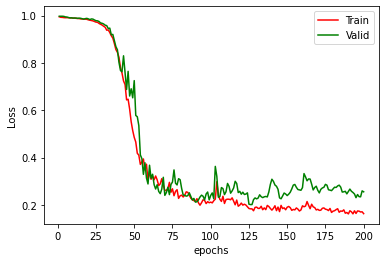

In [24]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

##Load  a trained model

In [25]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Generate predictions

###Visualize and save the inference results

/content/inference.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,4))


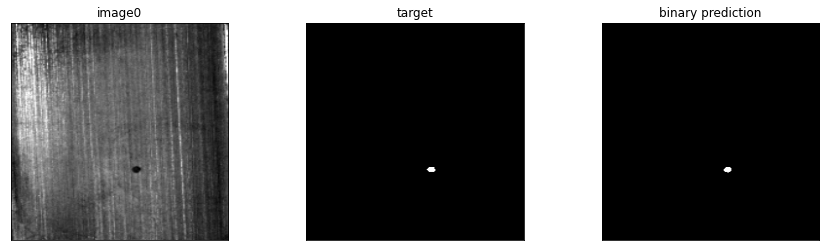

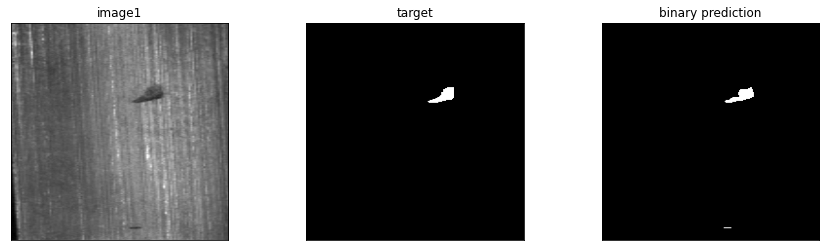

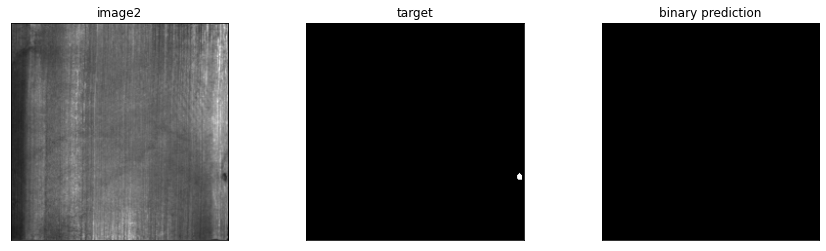

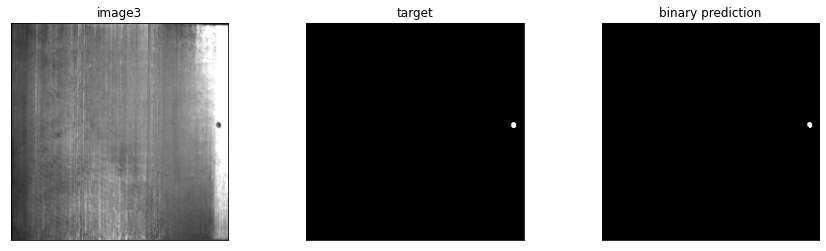

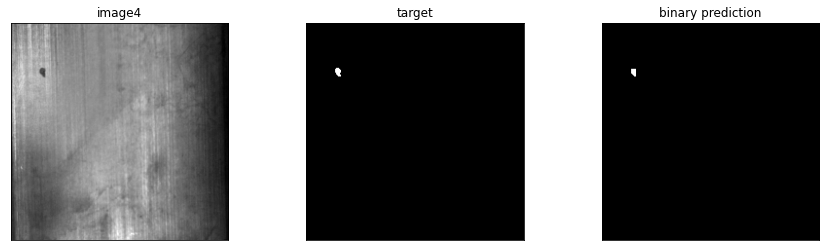

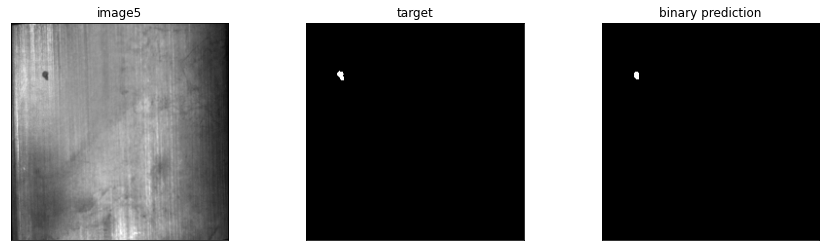

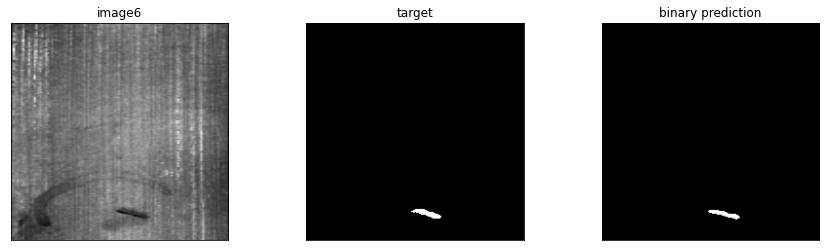

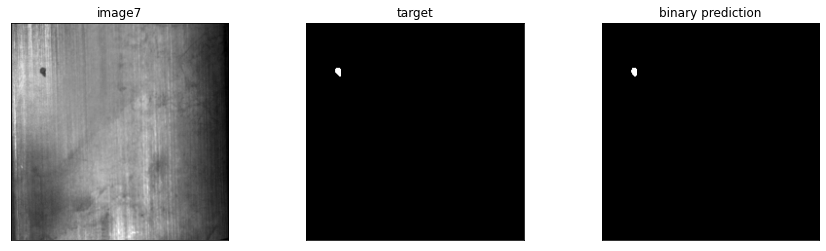

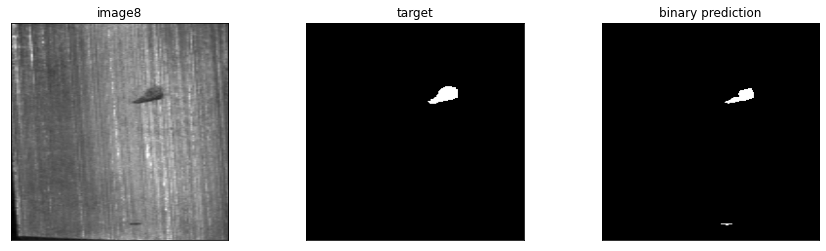

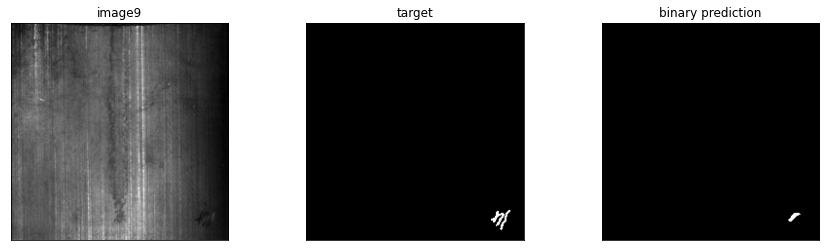

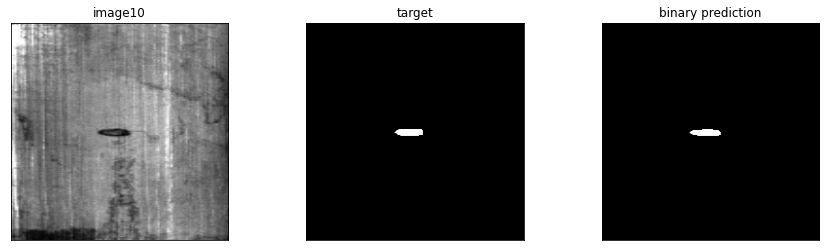

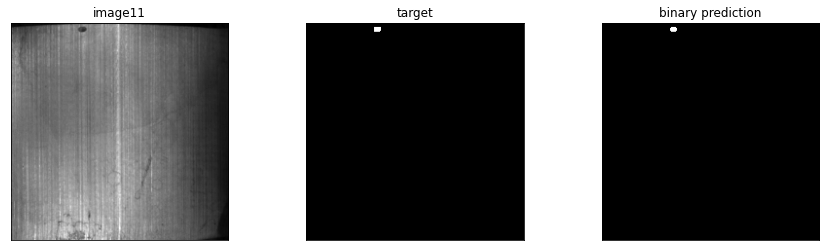

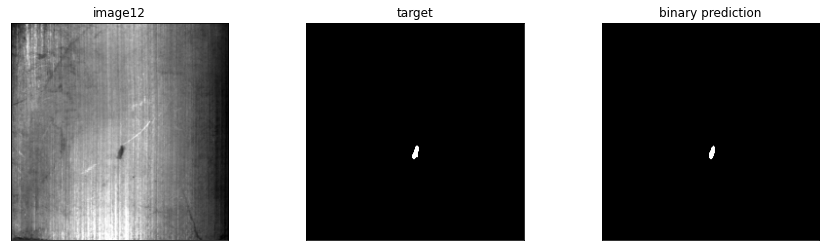

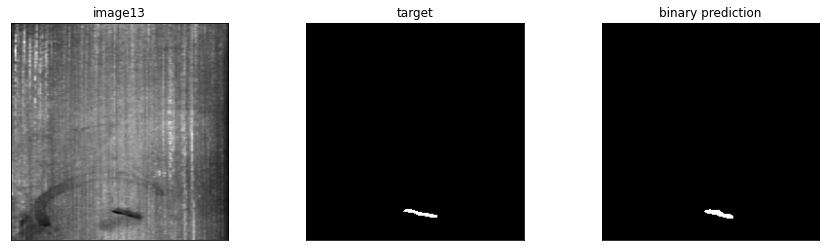

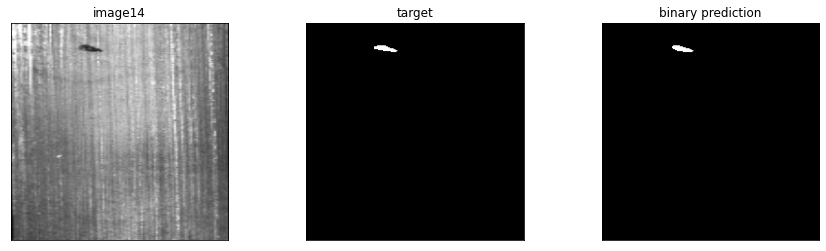

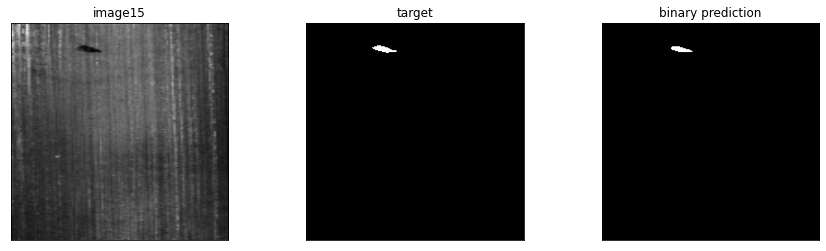

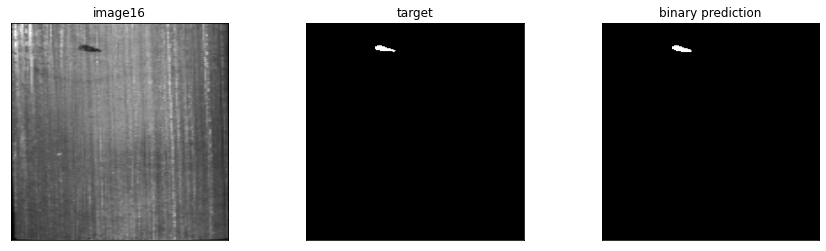

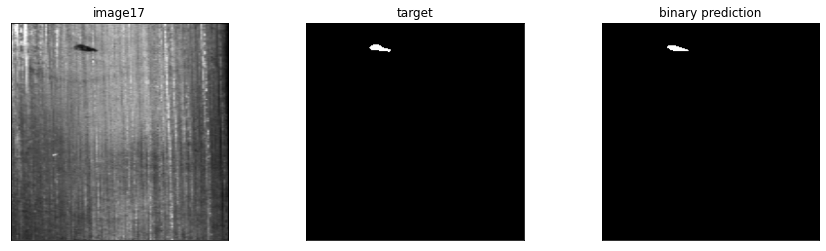

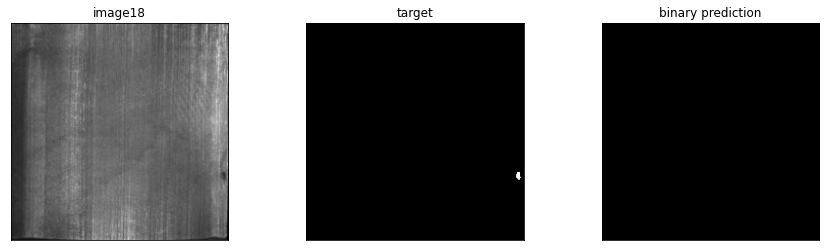

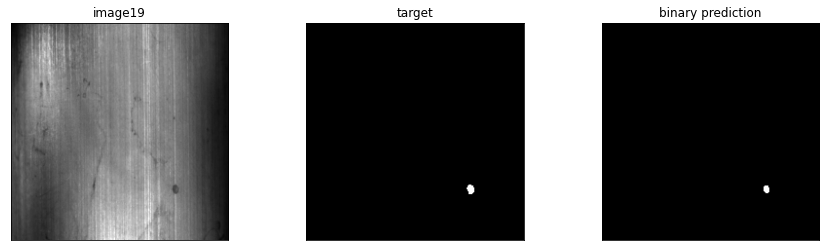

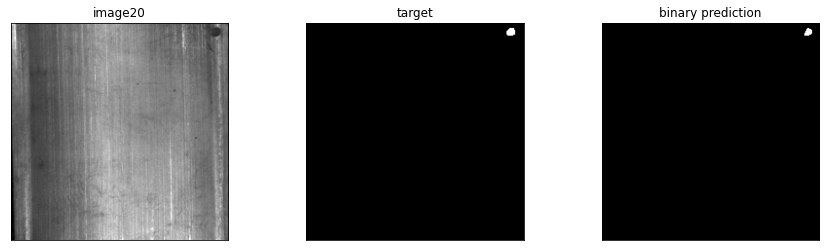

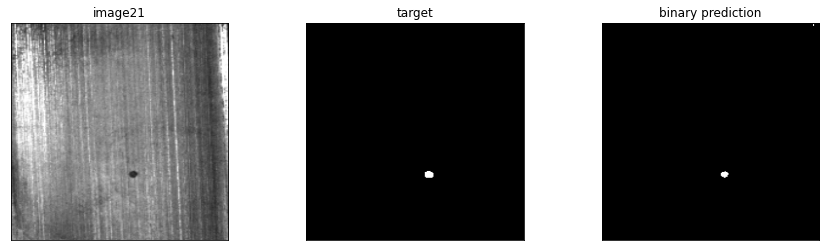

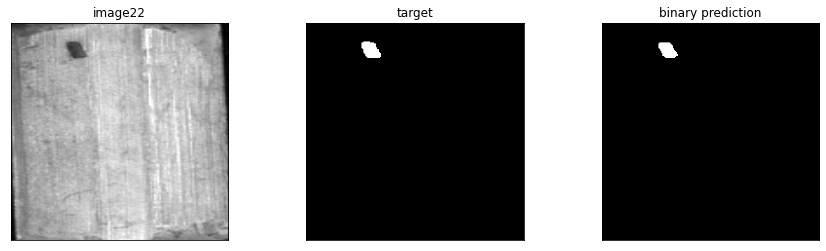

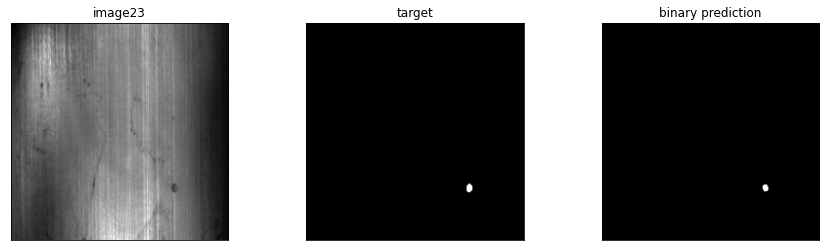

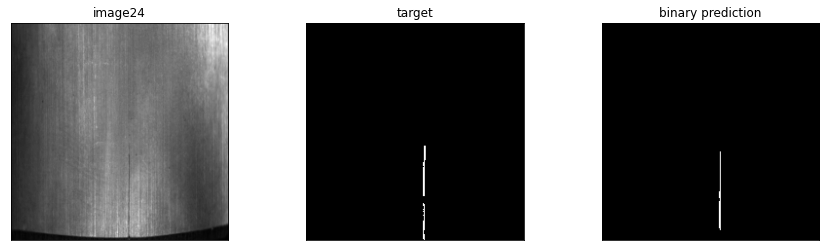

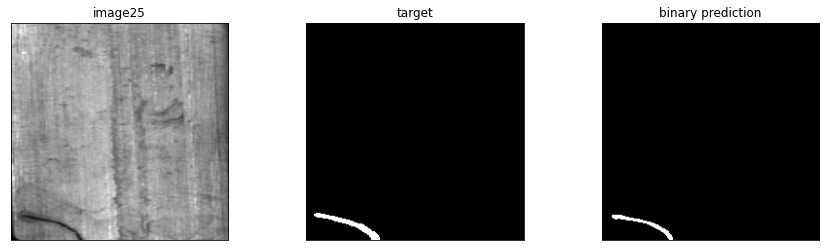

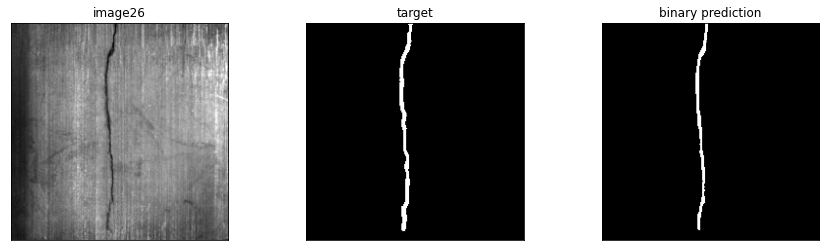

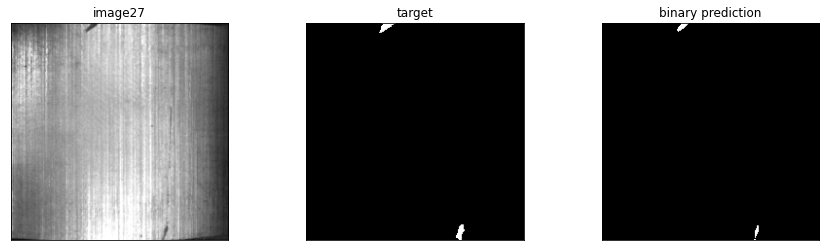

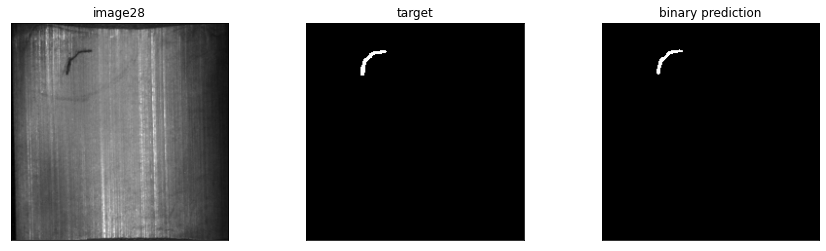

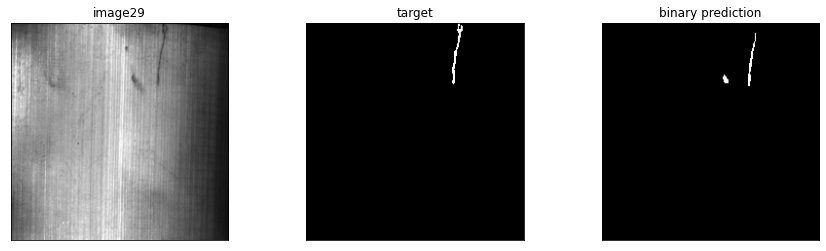

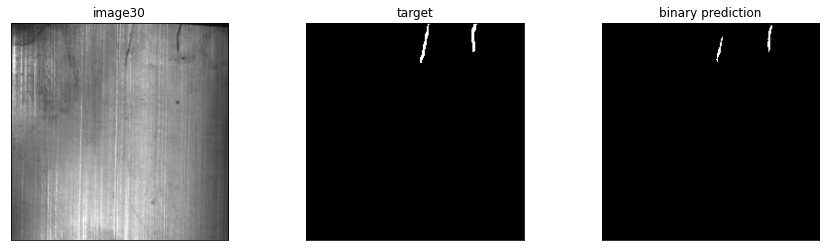

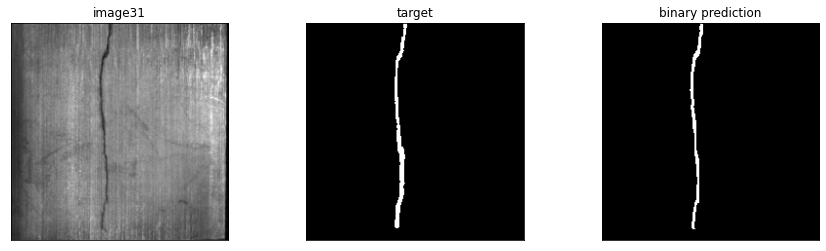

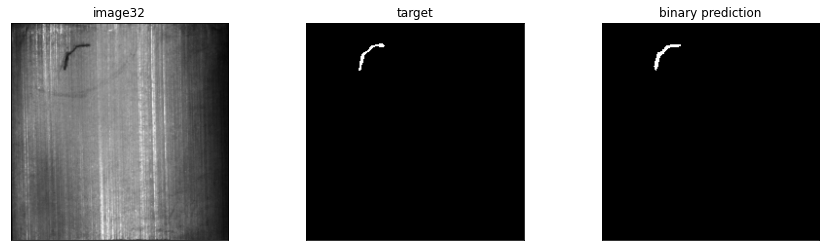

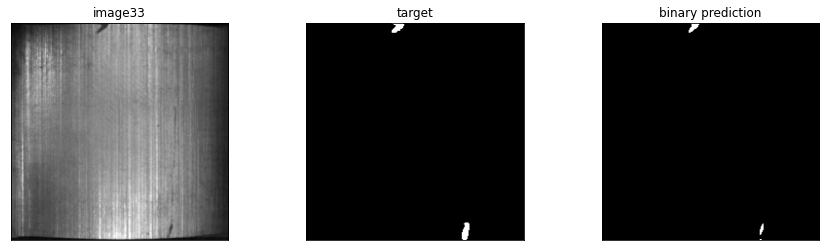

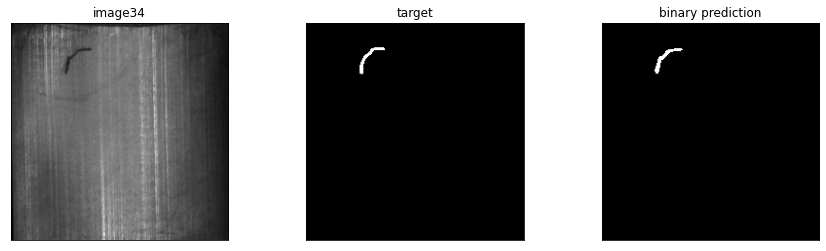

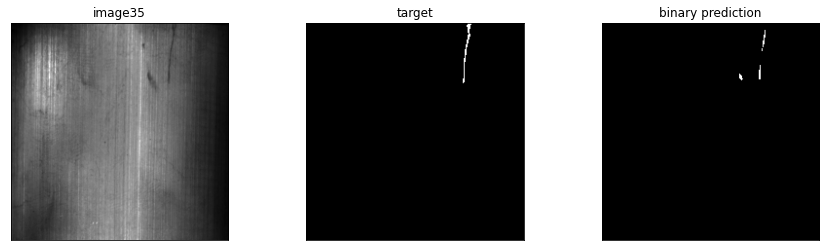

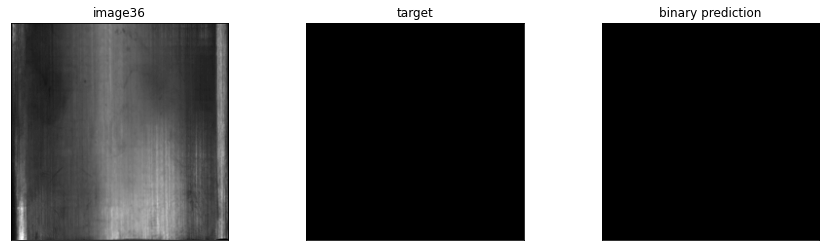

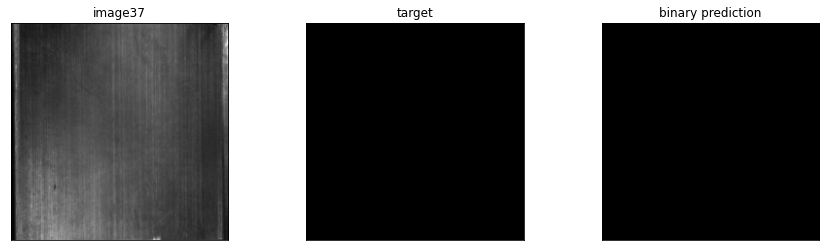

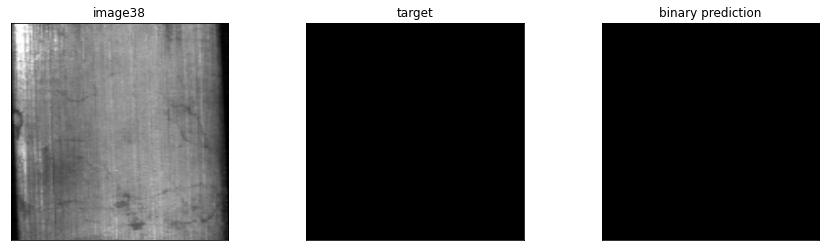

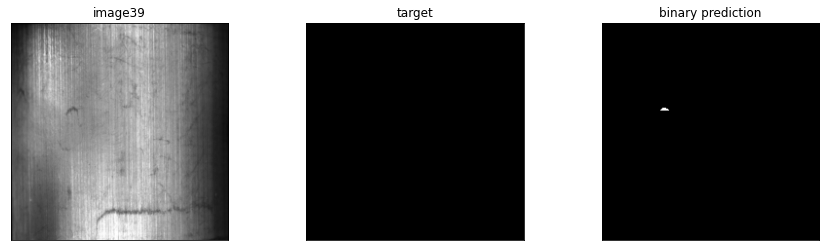

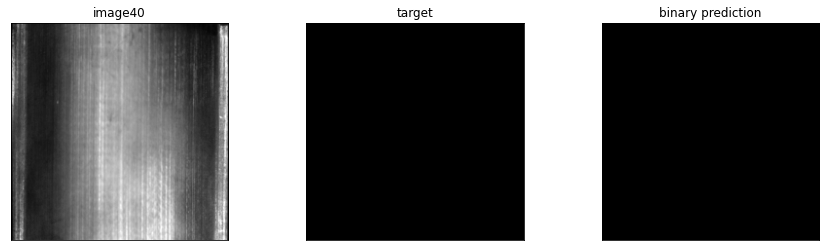

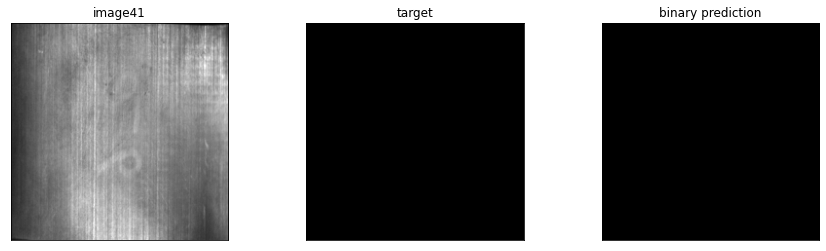

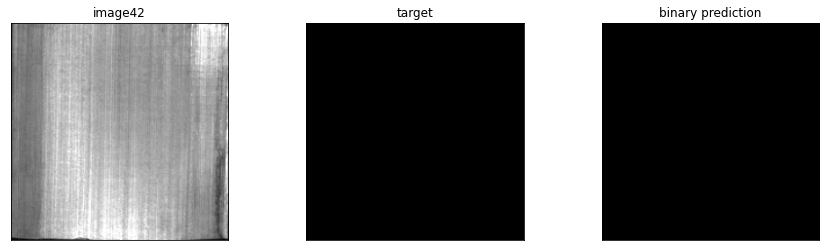

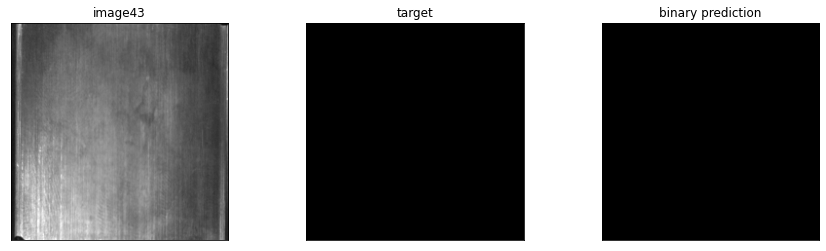

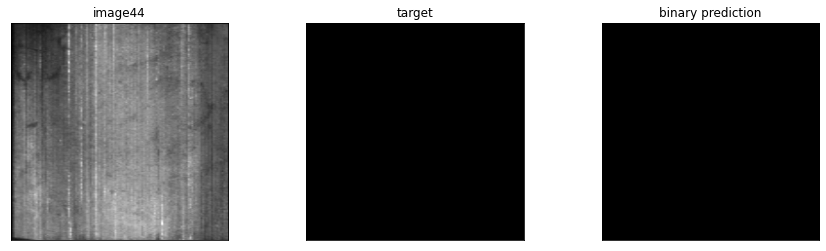

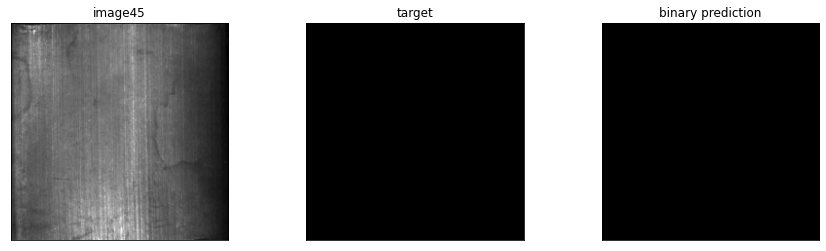

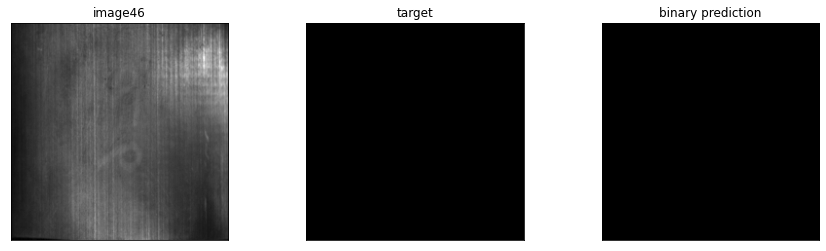

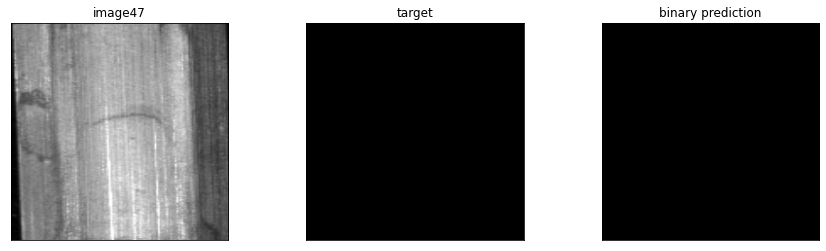

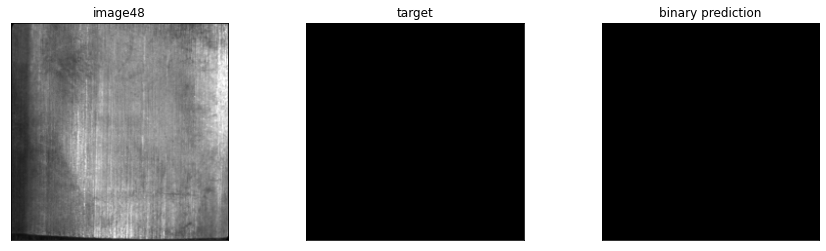

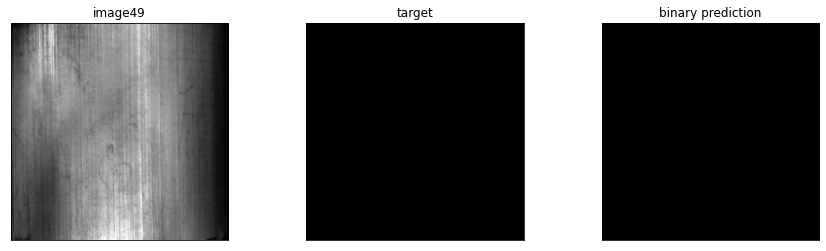

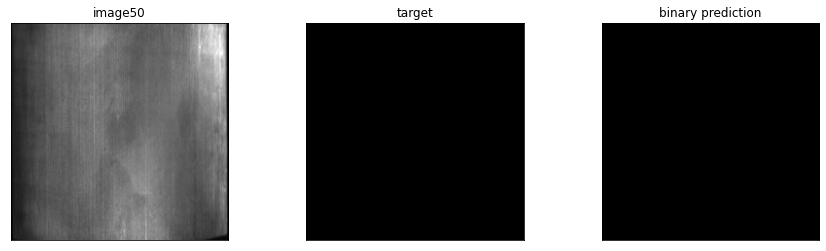

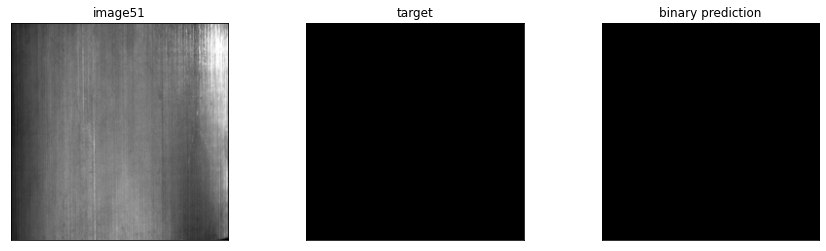

<Figure size 1080x288 with 0 Axes>

In [26]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

###Get the inference performance metrics

In [27]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)

In [28]:
###The inference performance metrics stats
df.describe()

,specificity,sensitivity,precision,F1_score,F2_score,DSC,F_beta,MAE,acc
count,53.000000,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,53.000000
mean,0.085960,5.858921e-02,6.435350e-02,6.083907e-02,5.939155e-02,6.083906e-02,6.249247e-02,6.138114e-05,0.085918
std,0.154049,1.390959e-01,1.419766e-01,1.403948e-01,1.395891e-01,1.403948e-01,1.411961e-01,1.219754e-04,0.154022
min,0.018868,1.125745e-110,1.859925e-110,1.402567e-110,1.222237e-110,1.402567e-110,1.616621e-110,1.488491e-88,0.018868
25%,0.024990,7.536462e-28,1.245154e-27,9.389688e-28,8.182444e-28,9.389689e-28,1.082271e-27,1.517036e-17,0.024990
50%,0.037009,2.314468e-02,3.172417e-02,2.480404e-02,2.446811e-02,2.480404e-02,2.922422e-02,2.344691e-05,0.036842
75%,0.071373,5.435598e-02,6.102949e-02,5.426366e-02,5.327696e-02,5.426366e-02,5.602229e-02,6.858214e-05,0.071340
max,0.999960,9.166667e-01,9.428571e-01,9.295775e-01,9.217877e-01,9.295775e-01,9.366812e-01,8.071598e-04,0.999900


In [29]:
#!pip install pipreqs
#!pipreqs
